<h1><center>WiDS Datathon 2022</center></h1>
<h2>Overview</h2>
<hr></hr>
The WiDS Datathon dataset was created in collaboration with Climate Change AI (CCAI) and Lawrence Berkeley National Laboratory (Berkeley Lab). WiDS Datathon participants will analyze differences in building energy efficiency, creating models to predict building energy consumption.
<h2>Agenda</h2>
<hr></hr>
<ol>
<li><a href='#eda'>EDA: Understand the Missing Values</a></li>
<li><a href='#features'>Feature Engineering</a></li>
<li><a href='#methods'>Impute Missing Data </a></li>  
<li><a href='#models'>Model Development using XGBoost</a> </li>  
</ol>

In [1]:
#Loading the relevant libraries 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV
from collections import deques
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm

C:\Users\nupur.gokhale\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#Reading the data
train = pd.read_csv('train.csv')

train.set_index('id',inplace=True)

train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
id,,,,,,,,,,,,,,,,,,,,,
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395


In [3]:
len(train.columns)

63

<a id='eda'></a>
# SECTION 1: Understand the Missing Values

In [4]:
#Describing the data types
pd.set_option('display.max_rows', 70)
types = train.dtypes.sample(len(train.columns))
types

cooling_degree_days            int64
days_above_80F                 int64
may_min_temp                   int64
days_above_100F                int64
april_max_temp                 int64
january_min_temp               int64
june_max_temp                  int64
year_built                   float64
october_max_temp               int64
building_class                object
october_avg_temp             float64
february_max_temp              int64
december_min_temp              int64
ELEVATION                    float64
october_min_temp               int64
site_eui                     float64
energy_star_rating           float64
days_below_30F                 int64
june_min_temp                  int64
heating_degree_days            int64
july_min_temp                  int64
days_above_90F                 int64
june_avg_temp                float64
days_with_fog                float64
september_avg_temp           float64
march_min_temp                 int64
august_avg_temp              float64
d

In [5]:
#Summary stats for just numeric data 
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
train.describe(include=numerics)

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui
count,75757.000000,7.575700e+04,73920.000000,49048.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,...,75757.000000,75757.000000,75757.000000,75757.000000,75757.000000,34675.000000,33946.000000,34675.000000,29961.000000,75757.000000
mean,4.367755,1.659839e+05,1952.306764,61.048605,39.506323,11.432343,34.310468,59.054952,11.720567,35.526837,...,0.876764,82.709809,14.058701,0.279539,0.002442,66.552675,62.779974,4.190601,109.142051,82.584693
std,1.471441,2.468758e+05,37.053619,28.663683,60.656596,9.381027,6.996108,5.355458,12.577272,8.866697,...,2.894244,25.282913,10.943996,2.252323,0.142140,131.147834,130.308106,6.458789,50.699751,58.255403
min,1.000000,9.430000e+02,0.000000,0.000000,-6.400000,-19.000000,10.806452,42.000000,-13.000000,13.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,12.000000,1.001169
25%,3.000000,6.237900e+04,1927.000000,40.000000,11.900000,6.000000,29.827586,56.000000,2.000000,31.625000,...,0.000000,72.000000,6.000000,0.000000,0.000000,1.000000,1.000000,1.000000,88.000000,54.528601
50%,5.000000,9.136700e+04,1951.000000,67.000000,25.000000,11.000000,34.451613,59.000000,9.000000,34.107143,...,0.000000,84.000000,12.000000,0.000000,0.000000,1.000000,1.000000,1.000000,104.000000,75.293716
75%,6.000000,1.660000e+05,1977.000000,85.000000,42.700000,13.000000,37.322581,62.000000,20.000000,40.879310,...,0.000000,97.000000,17.000000,0.000000,0.000000,1.000000,1.000000,1.000000,131.000000,97.277534
max,6.000000,6.385382e+06,2015.000000,100.000000,1924.500000,49.000000,64.758065,91.000000,48.000000,65.107143,...,31.000000,260.000000,185.000000,119.000000,16.000000,360.000000,360.000000,23.300000,311.000000,997.866120


**We can see that there are 0s in year_built and energy_star_rating that should probably be converted to NaN. So let's do that.**

In [6]:
#Replace 0s in the year_built and energy_star_rating columns with np.nan
cols_with_zero = ["year_built","energy_star_rating"]
train[cols_with_zero] = train[cols_with_zero].replace({'0':np.nan, 0:np.nan})

In [7]:
#Get the classes in each categorical variable
cols = train.columns
num_cols = train._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
for col in cat_cols:
    print (col,":", train[col].unique())

building_class : ['Commercial' 'Residential']
facility_type : ['Grocery_store_or_food_market'
 'Warehouse_Distribution_or_Shipping_center' 'Retail_Enclosed_mall'
 'Education_Other_classroom' 'Warehouse_Nonrefrigerated'
 'Warehouse_Selfstorage' 'Office_Uncategorized' 'Data_Center'
 'Commercial_Other' 'Mixed_Use_Predominantly_Commercial'
 'Office_Medical_non_diagnostic' 'Education_College_or_university'
 'Industrial' 'Laboratory' 'Public_Assembly_Entertainment_culture'
 'Retail_Vehicle_dealership_showroom' 'Retail_Uncategorized'
 'Lodging_Hotel' 'Retail_Strip_shopping_mall' 'Education_Uncategorized'
 'Health_Care_Inpatient' 'Public_Assembly_Drama_theater'
 'Public_Assembly_Social_meeting' 'Religious_worship'
 'Mixed_Use_Commercial_and_Residential' 'Office_Bank_or_other_financial'
 'Parking_Garage' 'Commercial_Unknown'
 'Service_Vehicle_service_repair_shop' 'Service_Drycleaning_or_Laundry'
 'Public_Assembly_Recreation' 'Service_Uncategorized'
 'Warehouse_Refrigerated' 'Food_Service_Uncate

**Now let's plot the missing data.**

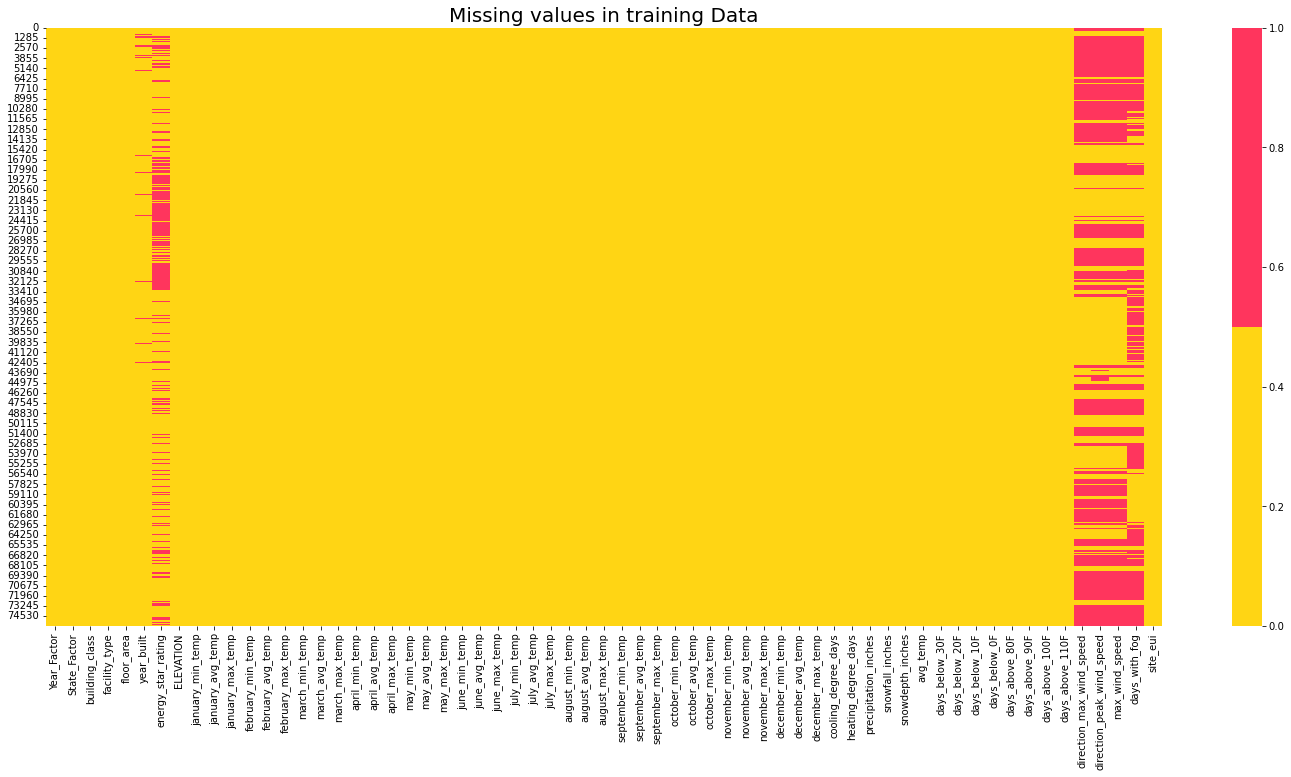

In [8]:
#Code from https://www.kaggle.com/usharengaraju/wids2022-lgbm-starter-w-b
plt.figure(figsize = (25,11))
sns.heatmap(train.isna().values, cmap = ['#ffd514','#ff355d'], xticklabels=train.columns)
plt.title("Missing values in training Data", size=20);

**Turning the viz into numbers below.**

In [9]:
#Code from https://www.kaggle.com/shrutisaxena/wids2022-starter-code
cols_with_missing = [col for col in train.columns 
                                 if train[col].isnull().any()]
miss_count =train.isna().sum()
miss_df = (pd.concat([miss_count.rename('Missing count'),miss_count.div(len(train)).rename('Missing value')],axis = 1).loc[miss_count.ne(0)])
miss_df.style.background_gradient(cmap="coolwarm")

,Missing count,Missing value
year_built,1843,0.024328
energy_star_rating,26710,0.352575
direction_max_wind_speed,41082,0.542287
direction_peak_wind_speed,41811,0.551909
max_wind_speed,41082,0.542287
days_with_fog,45796,0.604512


**Let's see which variables these missing values are most correlated to.**

In [10]:
num_train = train.select_dtypes(include=numerics)

corr = num_train.corr()
cols_no_missing = list(set(num_train.columns)-set(cols_with_missing))
cols_no_missing.sort()
corr_missing = corr.loc[cols_no_missing,cols_with_missing]

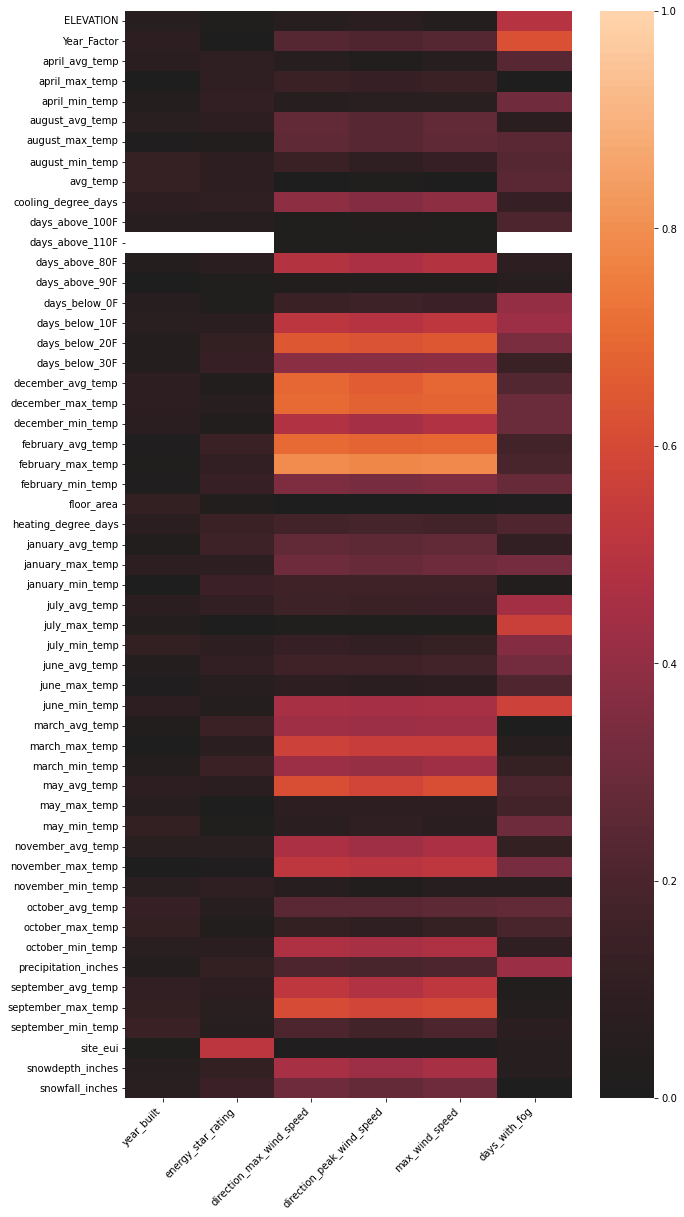

In [11]:
plt.figure(figsize = (10,20))
ax = sns.heatmap(
    abs(corr_missing),
    vmin=0, vmax=1, center=0,
    square=False
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

- Wind speed columns are highly correlated to temperatures in Dec, Feb, and days below 10F and 20F. 
- energy_star_rating is correlated to site_eui
- days_with_fog is loosely correlated to june/july temps and year_factor and elevation
- year_built isn't highly correlated to anything

<a href='#eda'>Go to start of section </a>

<hr></hr>

<a id='features'></a>
# SECTION 2: Feature Engineering

**Below, I create a few new features for the dataset to see if we are able to extract signal from fewer datapoints.**
1. <a href='#year_built'>Bucketing Year Built into Categories  </a>

2. <a href='#deviation'>Deviation from Room Temperature </a>

3. <a href='#building'>Grouping Building Categories </a>

4. <a href='#region'>Create Regional Clusters </a>

5. <a href='#extreme'>Extreme Temperature Variable </a>

<a id='year_built'></a>
## 1. Bucketing Year Built into Categories 

array([[<AxesSubplot:title={'center':'year_built'}>]], dtype=object)

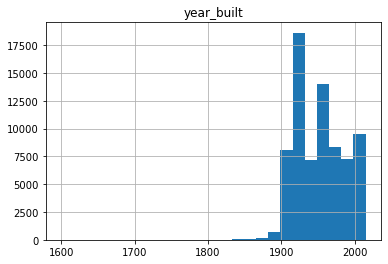

In [12]:
#Create new column for year 
train.hist(column='year_built',bins=25)

In [13]:
def label_year(row):
    if row['year_built'] < 1900:
        return 'pre-1900'
    if row['year_built'] >= 1900 and row['year_built'] < 1920:
        return '1900-1920'
    if row['year_built'] >= 1920 and row['year_built'] < 1940:
        return '1920-1940'
    if row['year_built'] >= 1940 and row['year_built'] < 1960:
        return '1940-1960'
    if row['year_built'] >= 1960 and row['year_built'] < 1980:
        return '1960-1980'
    if row['year_built'] >= 1980 and row['year_built'] < 2000:
        return '1980-2000'
    if row['year_built'] >= 2000:
        return 'post-2000'
    else:
        return row['year_built']

train['year_built_cat'] = train.apply (lambda row: label_year(row), axis=1)

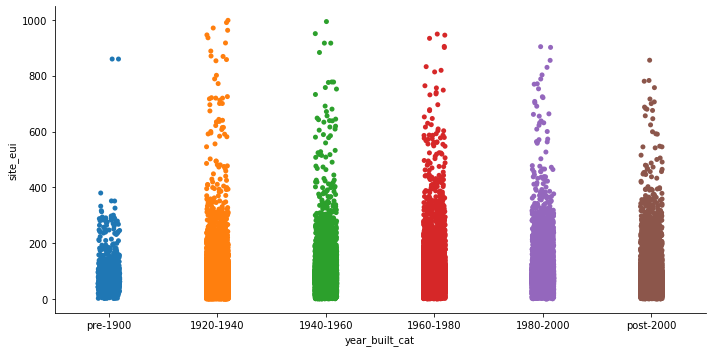

In [14]:
sns.catplot( x="year_built_cat", 
            y="site_eui", 
            data=train, 
            height=5, 
            aspect=2,
            order = ['pre-1900','1920-1940','1940-1960','1960-1980','1980-2000','post-2000'])

<a id='deviation'></a>

## 2. Deviation from Room Temp

In [15]:
import calendar
def label_deviation(row,month):
    col = month.lower() + '_avg_temp'
    month_no = list(calendar.month_abbr).index(month[:3])
    days = calendar.monthrange(2022,month_no)[1]
    return (68-row[col])*days

In [16]:
for i in range(1,13):
    month = calendar.month_name[i]
    new_col = 'deviation_' + month
    train[new_col] = train.apply (lambda row: label_deviation(row,month), axis=1)

In [17]:
keys = [c for c in train if c.startswith('deviation_')]
train_melt = pd.melt(train, id_vars='site_eui', value_vars=keys, value_name='key')
d=deque(train_melt.variable.unique()[::-1])

Text(0.5, 1.0, "['deviation_May', 'deviation_April', 'deviation_March']")

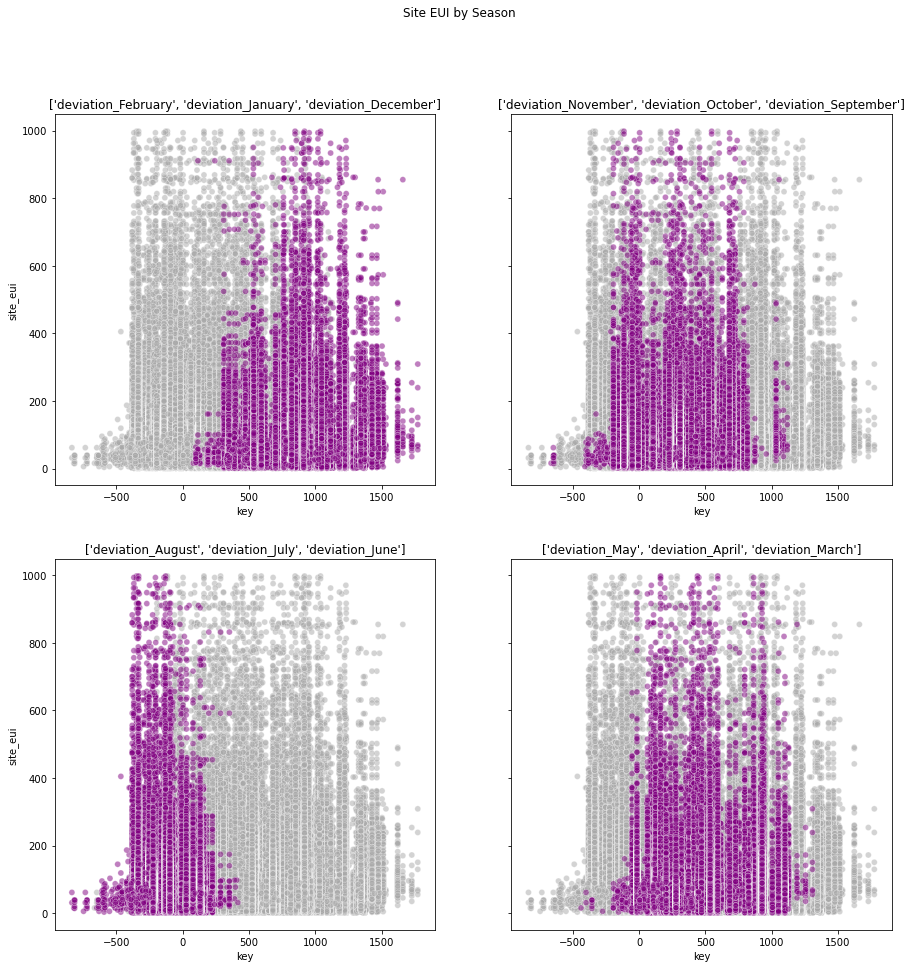

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)
fig.suptitle('Site EUI by Season')

#Winter
d.rotate(-1)
hue_order = list(d)
palette = {c:'purple' if c in list(d)[-3:] else 'darkgrey' for c in list(d)}
sns.scatterplot(
    ax = axes[0,0],
    data=train_melt.sort_values('variable', key=np.vectorize(hue_order.index)),
    x='key', 
    y='site_eui', 
    hue='variable', 
    hue_order = hue_order, 
    legend=None, 
    palette=palette,
    alpha=0.5)
axes[0,0].set_title(list(d)[-3:])

#Fall
d.rotate(-3)
hue_order = list(d)
palette = {c:'purple' if c in list(d)[-3:] else 'darkgrey' for c in list(d)}
sns.scatterplot(
    ax = axes[0,1],
    data=train_melt.sort_values('variable', key=np.vectorize(hue_order.index)),
    x='key', 
    y='site_eui', 
    hue='variable', 
    hue_order = hue_order, 
    legend=None, 
    palette=palette,
    alpha=0.5)
axes[0,1].set_title(list(d)[-3:])

#Summer
d.rotate(-3)
hue_order = list(d)
palette = {c:'purple' if c in list(d)[-3:] else 'darkgrey' for c in list(d)}
sns.scatterplot(
    ax = axes[1,0],
    data=train_melt.sort_values('variable', key=np.vectorize(hue_order.index)),
    x='key', 
    y='site_eui', 
    hue='variable', 
    hue_order = hue_order, 
    legend=None, 
    palette=palette,
    alpha=0.5)
axes[1,0].set_title(list(d)[-3:])

#Spring
d.rotate(-3)
hue_order = list(d)
palette = {c:'purple' if c in list(d)[-3:] else 'darkgrey' for c in list(d)}
sns.scatterplot(
    ax = axes[1,1],
    data=train_melt.sort_values('variable', key=np.vectorize(hue_order.index)),
    x='key', 
    y='site_eui', 
    hue='variable', 
    hue_order = hue_order, 
    legend=None, 
    palette=palette,
    alpha=0.5)
axes[1,1].set_title(list(d)[-3:])

<a id='building'></a>
## 3. Grouping Building Categories

In [19]:
order = train.groupby('facility_type')['site_eui'].median().sort_values(ascending=False)
high_eui = order[:20].index
med_eui = order[20:40].index
low_eui = order[40:60].index

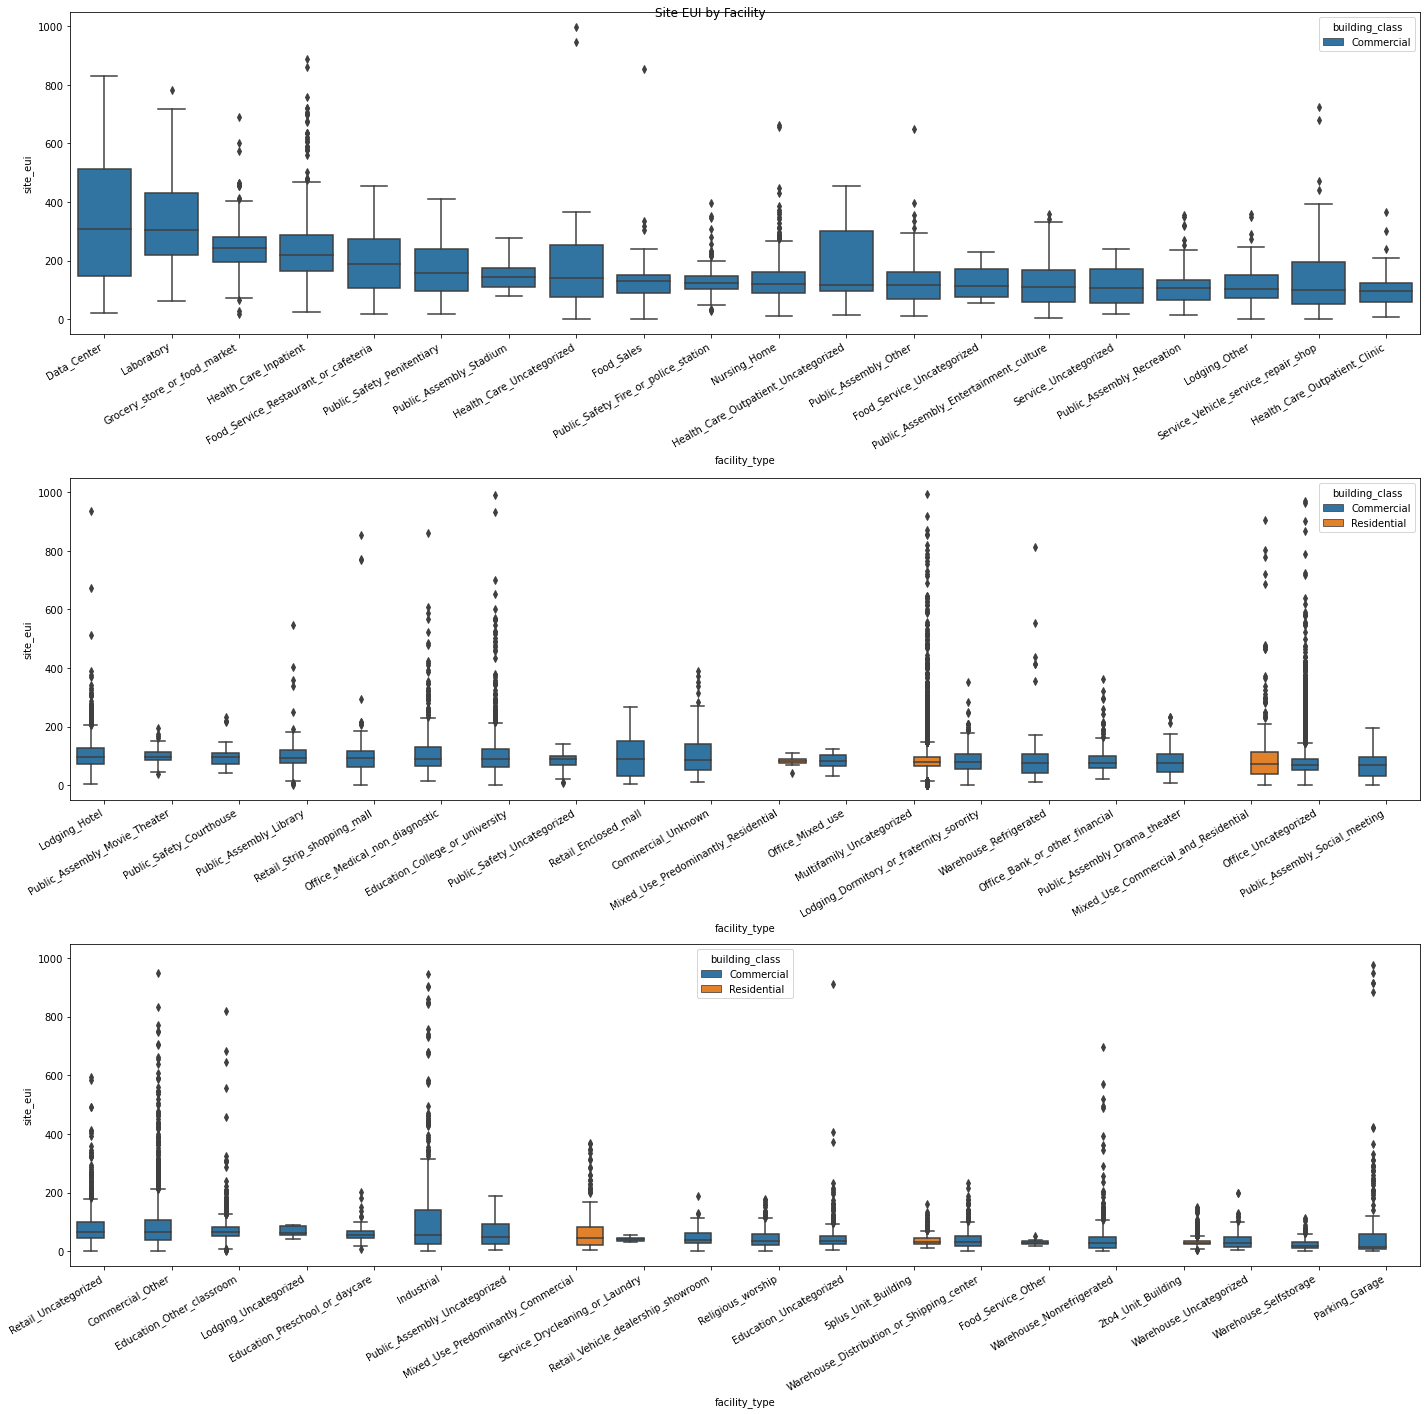

In [20]:
fig, axes = plt.subplots(3,1, figsize=(20,20), sharey=True)
fig.suptitle('Site EUI by Facility')
sns.boxplot(ax = axes[0],
            x="facility_type", 
            y="site_eui", 
            data=train[train['facility_type'].isin(high_eui)],
            hue = 'building_class',
            order = high_eui)

tix = axes[0].set_xticklabels(high_eui, rotation=30, ha='right')

sns.boxplot(ax = axes[1],
            x="facility_type", 
            y="site_eui", 
            data=train[train['facility_type'].isin(med_eui)],
            hue = 'building_class',
            order = med_eui)

tix = axes[1].set_xticklabels(med_eui, rotation=30, ha='right')

sns.boxplot(ax = axes[2],
            x="facility_type", 
            y="site_eui", 
            data=train[train['facility_type'].isin(low_eui)],
            hue = 'building_class',
            order = low_eui)

tix = axes[2].set_xticklabels(low_eui, rotation=30, ha='right')

fig.tight_layout()


In [21]:
# Create facility categories based on median temperature
eui_300above = order[:2].index
eui_250_180 = order[2:5].index
eui_160_140 = order[5:8].index
eui_140_110 = order[8:14].index
eui_110_90 = order[14:27].index
eui_90_70 = order[27:38].index
eui_70_50 = order[38:46].index
eui_50below = order[46:].index

In [22]:
def label_facility(row):
    if row['facility_type'] in eui_300above:
        return 'eui_300above'
    if row['facility_type'] in eui_250_180:
        return 'eui_250_180'
    if row['facility_type'] in eui_160_140:
        return 'eui_160_140'
    if row['facility_type'] in eui_140_110:
        return 'eui_140_110'
    if row['facility_type'] in eui_110_90:
        return 'eui_110_90'
    if row['facility_type'] in eui_90_70:
        return 'eui_90_70'
    if row['facility_type'] in eui_70_50:
        return 'eui_70_50'   
    if row['facility_type'] in eui_50below:
        return 'eui_50below' 
    else:
        return 'other'

train['facility_cat'] = train.apply (lambda row: label_facility(row), axis=1)

<a id='region'></a>

## 4. Create a Regional Clusters

First, we will do PCA on our data since it is highly dimensional. Then, we will create the clusters. 
Link to [article](https://365datascience.com/tutorials/python-tutorials/pca-k-means/).

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = train[['site_eui','ELEVATION', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inches',
       'snowdepth_inches', 'avg_temp', 'days_below_30F', 'days_below_20F',
       'days_below_10F', 'days_below_0F', 'days_above_80F', 'days_above_90F',
       'days_above_100F', 'days_above_110F', 'deviation_January',
       'deviation_February', 'deviation_March', 'deviation_April',
       'deviation_May', 'deviation_June', 'deviation_July', 'deviation_August',
       'deviation_September', 'deviation_October', 'deviation_November',
       'deviation_December']]

df.head()

,site_eui,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,...,deviation_March,deviation_April,deviation_May,deviation_June,deviation_July,deviation_August,deviation_September,deviation_October,deviation_November,deviation_December
id,,,,,,,,,,,,,,,,,,,,,
0,248.682615,2.4,115,2960,16.59,0.0,0,56.972603,0,0,...,443.5,375.0,345.5,225.0,163.5,181.0,100.5,154.5,426.0,580.5
1,26.500150,1.8,115,2960,16.59,0.0,0,56.972603,0,0,...,443.5,375.0,345.5,225.0,163.5,181.0,100.5,154.5,426.0,580.5
2,24.693619,1.8,115,2960,16.59,0.0,0,56.972603,0,0,...,443.5,375.0,345.5,225.0,163.5,181.0,100.5,154.5,426.0,580.5
3,48.406926,1.8,115,2960,16.59,0.0,0,56.972603,0,0,...,443.5,375.0,345.5,225.0,163.5,181.0,100.5,154.5,426.0,580.5
4,3.899395,2.4,115,2960,16.59,0.0,0,56.972603,0,0,...,443.5,375.0,345.5,225.0,163.5,181.0,100.5,154.5,426.0,580.5


In [24]:
scaler = StandardScaler()
scaled_features = StandardScaler().fit_transform(df.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
scaled_features_df.head()

,site_eui,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,...,deviation_March,deviation_April,deviation_May,deviation_June,deviation_July,deviation_August,deviation_September,deviation_October,deviation_November,deviation_December
id,,,,,,,,,,,,,,,,,,,,,
0,2.851221,-0.611748,-2.776721,-1.655776,-2.439607,-1.635885,-0.940595,0.355007,-1.767376,-1.205856,...,-1.385627,-0.68593,2.466149,3.692394,3.391255,3.453236,1.372888,-1.623867,-1.38657,-1.303147
1,-0.962742,-0.621640,-2.776721,-1.655776,-2.439607,-1.635885,-0.940595,0.355007,-1.767376,-1.205856,...,-1.385627,-0.68593,2.466149,3.692394,3.391255,3.453236,1.372888,-1.623867,-1.38657,-1.303147
2,-0.993753,-0.621640,-2.776721,-1.655776,-2.439607,-1.635885,-0.940595,0.355007,-1.767376,-1.205856,...,-1.385627,-0.68593,2.466149,3.692394,3.391255,3.453236,1.372888,-1.623867,-1.38657,-1.303147
3,-0.586692,-0.621640,-2.776721,-1.655776,-2.439607,-1.635885,-0.940595,0.355007,-1.767376,-1.205856,...,-1.385627,-0.68593,2.466149,3.692394,3.391255,3.453236,1.372888,-1.623867,-1.38657,-1.303147
4,-1.350704,-0.611748,-2.776721,-1.655776,-2.439607,-1.635885,-0.940595,0.355007,-1.767376,-1.205856,...,-1.385627,-0.68593,2.466149,3.692394,3.391255,3.453236,1.372888,-1.623867,-1.38657,-1.303147


In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(scaled_features_df)

<BarContainer object of 20 artists>

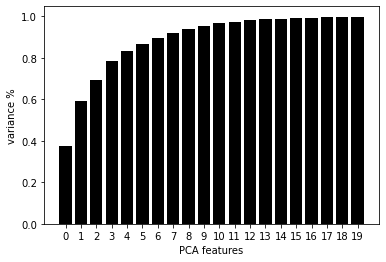

In [26]:
features = range(pca.n_components_)
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.bar(features, pca.explained_variance_ratio_.cumsum(), color='black')

A rule of thumb is to preserve around 80 % of the variance. So, in this instance, we decide to keep 4 components.

In [27]:
pca = PCA(n_components=4)
principalComponents = pca.fit_transform(scaled_features_df)

scores_pca = pca.transform(scaled_features_df)

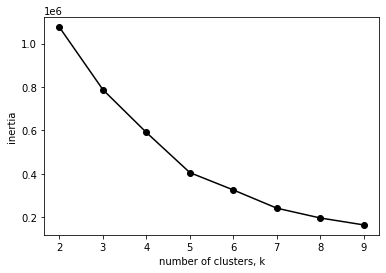

In [28]:
ks = range(2, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, init='k-means++')
    
    # Fit model to samples
    model.fit(scores_pca)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

We can choose 5 number of clusters as this is the elbow point. Now, we run k-means where the number of clusters is 5. 

In [29]:
model = KMeans(n_clusters=5, init='k-means++')
model.fit(scores_pca)

KMeans(n_clusters=5)

In [30]:
train = pd.concat([train, pd.DataFrame(scores_pca)],axis=1)
train.columns.values[-4:] = ['Component 1', 'Component 2', 'Component 3','Component 4']
train['Kmeans clusters'] = model.labels_
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,deviation_September,deviation_October,deviation_November,deviation_December,facility_cat,Component 1,Component 2,Component 3,Component 4,Kmeans clusters
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,100.5,154.5,426.0,580.5,eui_250_180,-7.858960,-3.919021,2.995271,0.025138,2
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,100.5,154.5,426.0,580.5,eui_50below,-8.078417,-3.963522,3.093942,0.132618,2
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,100.5,154.5,426.0,580.5,eui_90_70,-8.080195,-3.963893,3.094751,0.133525,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,100.5,154.5,426.0,580.5,eui_70_50,-8.056851,-3.959025,3.084134,0.121607,2
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,100.5,154.5,426.0,580.5,eui_50below,-8.099929,-3.969274,3.104862,0.148163,2


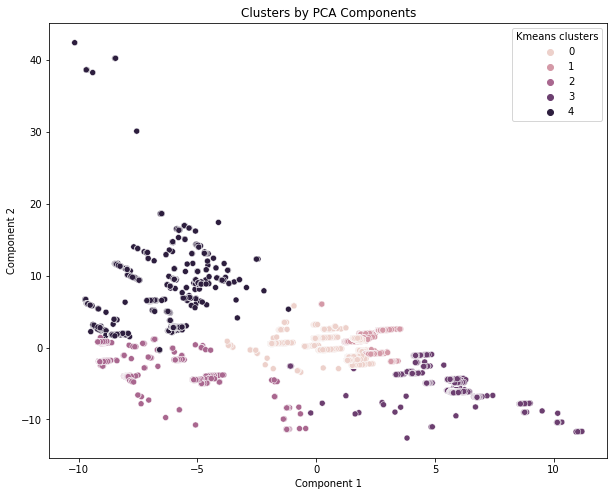

In [32]:
x = train['Component 1']
y = train['Component 2']
plt.figure(figsize = (10,8))
sns.scatterplot(x= x, y = y, hue = train['Kmeans clusters'])
plt.title('Clusters by PCA Components')
plt.show()

<a id='extreme'></a>
## 5. Extreme Temperature Variable

This will be based on days below 30F and days above 110F.

In [33]:
train['extreme_temp_days'] = train['days_below_30F'] + train['days_above_110F']
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,deviation_October,deviation_November,deviation_December,facility_cat,Component 1,Component 2,Component 3,Component 4,Kmeans clusters,extreme_temp_days
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,154.5,426.0,580.5,eui_250_180,-7.858960,-3.919021,2.995271,0.025138,2,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,154.5,426.0,580.5,eui_50below,-8.078417,-3.963522,3.093942,0.132618,2,0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,154.5,426.0,580.5,eui_90_70,-8.080195,-3.963893,3.094751,0.133525,2,0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,154.5,426.0,580.5,eui_70_50,-8.056851,-3.959025,3.084134,0.121607,2,0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,154.5,426.0,580.5,eui_50below,-8.099929,-3.969274,3.104862,0.148163,2,0


<a href='#features'>Go to start of section </a>

<hr></hr>

<a id='methods'></a>
# SECTION 3: Methods to deal with missing data

**Below, I will go into two different ways of dealing with missing data.**
1. <a href='#impute1'>Simple Imputer with Median </a>
    - <a href='https://towardsdatascience.com/imputing-missing-values-using-the-simpleimputer-class-in-sklearn-99706afaff46'>Source</a>
    
2. <a href='#impute2'>Predictive Model Based Imputation </a>
    - <a href='https://medium.com/swlh/impute-missing-values-the-right-way-c63735fccccd'>Source</a>

<a id='impute1'></a>
## 1. Simple Imputer

In [60]:
from sklearn.impute import SimpleImputer

#One hot code the data
train_encoded = pd.get_dummies(train)

my_imputer = SimpleImputer(strategy='median', missing_values=np.nan)
simple_impute_train = pd.DataFrame(my_imputer.fit_transform(train_encoded),columns = train_encoded.columns, index=train_encoded.index)
print ("Number of NAs:", simple_impute_train.isna().sum().sum())

Number of NAs: 0


<a id='impute2'></a>
## 2. Predictive Model Based Imputation

In [111]:
#Define a function to select features 
def impute_data(target_var, target_train, target_test, num_features_to_select):
    
    #Select features for our imputation model
    feature_names = list(target_train.drop(target_var,axis=1).columns)
    train_pool = Pool(target_train.drop(target_var,axis=1), target_train[target_var], feature_names=feature_names)
    test_pool = Pool(target_test.drop(target_var,axis=1), target_test[target_var], feature_names=feature_names)
    
    model = CatBoostRegressor(iterations=1000, random_seed=0)
    
    summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-156',
    num_features_to_select=num_features_to_select,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    logging_level='Silent',
    plot=True
    )
    
    
    #Train model with selected features
    train_dataset = Pool(target_train[summary['selected_features_names']],target_train[target_var])

    grid = {  'depth':[int(x) for x in np.linspace(2, 10, num = 5)],
          'iterations':[int(x) for x in np.linspace(100, 500, num = 5)],
          'learning_rate':[0.001,0.03,0.1], 
          'l2_leaf_reg':[0.2, 0.5, 1,3,5]
       }

    cat = CatBoostRegressor(loss_function='RMSE',logging_level='Silent')

    randomized_search_result = cat.randomized_search(grid, train_dataset,plot=False)
    
    cat = CatBoostRegressor(**randomized_search_result['params'])
    cat.fit(target_train.drop(target_var,axis=1)[summary['selected_features_names']],target_train[target_var],verbose=False, plot=False)

    
    test_predict = cat.predict(target_test.drop(target_var,axis=1)[summary['selected_features_names']])
    return cat, test_predict, summary


In [81]:
#Define a function to calculate the RMSE 
def rmse(a,p):
    return np.sqrt(mse(a,p))

### 2.1 Energy Star Rating 

In [82]:
target_var = 'energy_star_rating'

#Remove all NA columns except for the target variable we are imputing
df_na = train.drop(['direction_max_wind_speed','direction_peak_wind_speed','days_with_fog','max_wind_speed','site_eui'],axis=1) 

#Fill missing year columns with 0s
df_na[['year_built','year_built_cat']] = df_na[['year_built','year_built_cat']].fillna(0)
df_na = pd.get_dummies(df_na)

#All rows where the variable is NA go into target_missing; the rest go into target_present
target_missing = df_na.loc[df_na[target_var].isnull()==True].copy()
target_present = df_na.loc[df_na[target_var].isnull()==False].copy()
    
#Set aside some data to test the imputation model
target_train, target_test = train_test_split(target_present, test_size=0.2, random_state=42)
target_train.shape, target_test.shape

((39237, 158), (9810, 158))

In [83]:
cat, test_predict, summary = impute_data(target_var, target_train, target_test, num_features_to_select=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 46.5145020	best: 46.5145020 (0)	total: 3.87s	remaining: 34.8s
1:	loss: 46.5199426	best: 46.5145020 (0)	total: 7.85s	remaining: 31.4s
2:	loss: 62.0231385	best: 46.5145020 (0)	total: 8.87s	remaining: 20.7s
3:	loss: 23.1395451	best: 23.1395451 (3)	total: 11.3s	remaining: 17s
4:	loss: 19.9219945	best: 19.9219945 (4)	total: 14.5s	remaining: 14.5s
5:	loss: 21.2878562	best: 19.9219945 (4)	total: 20.5s	remaining: 13.7s
6:	loss: 18.5802182	best: 18.5802182 (6)	total: 26.8s	remaining: 11.5s
7:	loss: 23.2715161	best: 18.5802182 (6)	total: 29.5s	remaining: 7.37s
8:	loss: 18.0490828	best: 18.0490828 (8)	total: 39.2s	remaining: 4.36s
9:	loss: 19.4610713	best: 18.0490828 (8)	total: 53.4s	remaining: 0us
Estimating final quality...


In [84]:
print("RMSE of holdout data is ", round(rmse(target_test[target_var],test_predict),2))

RMSE of holdout data is  17.95


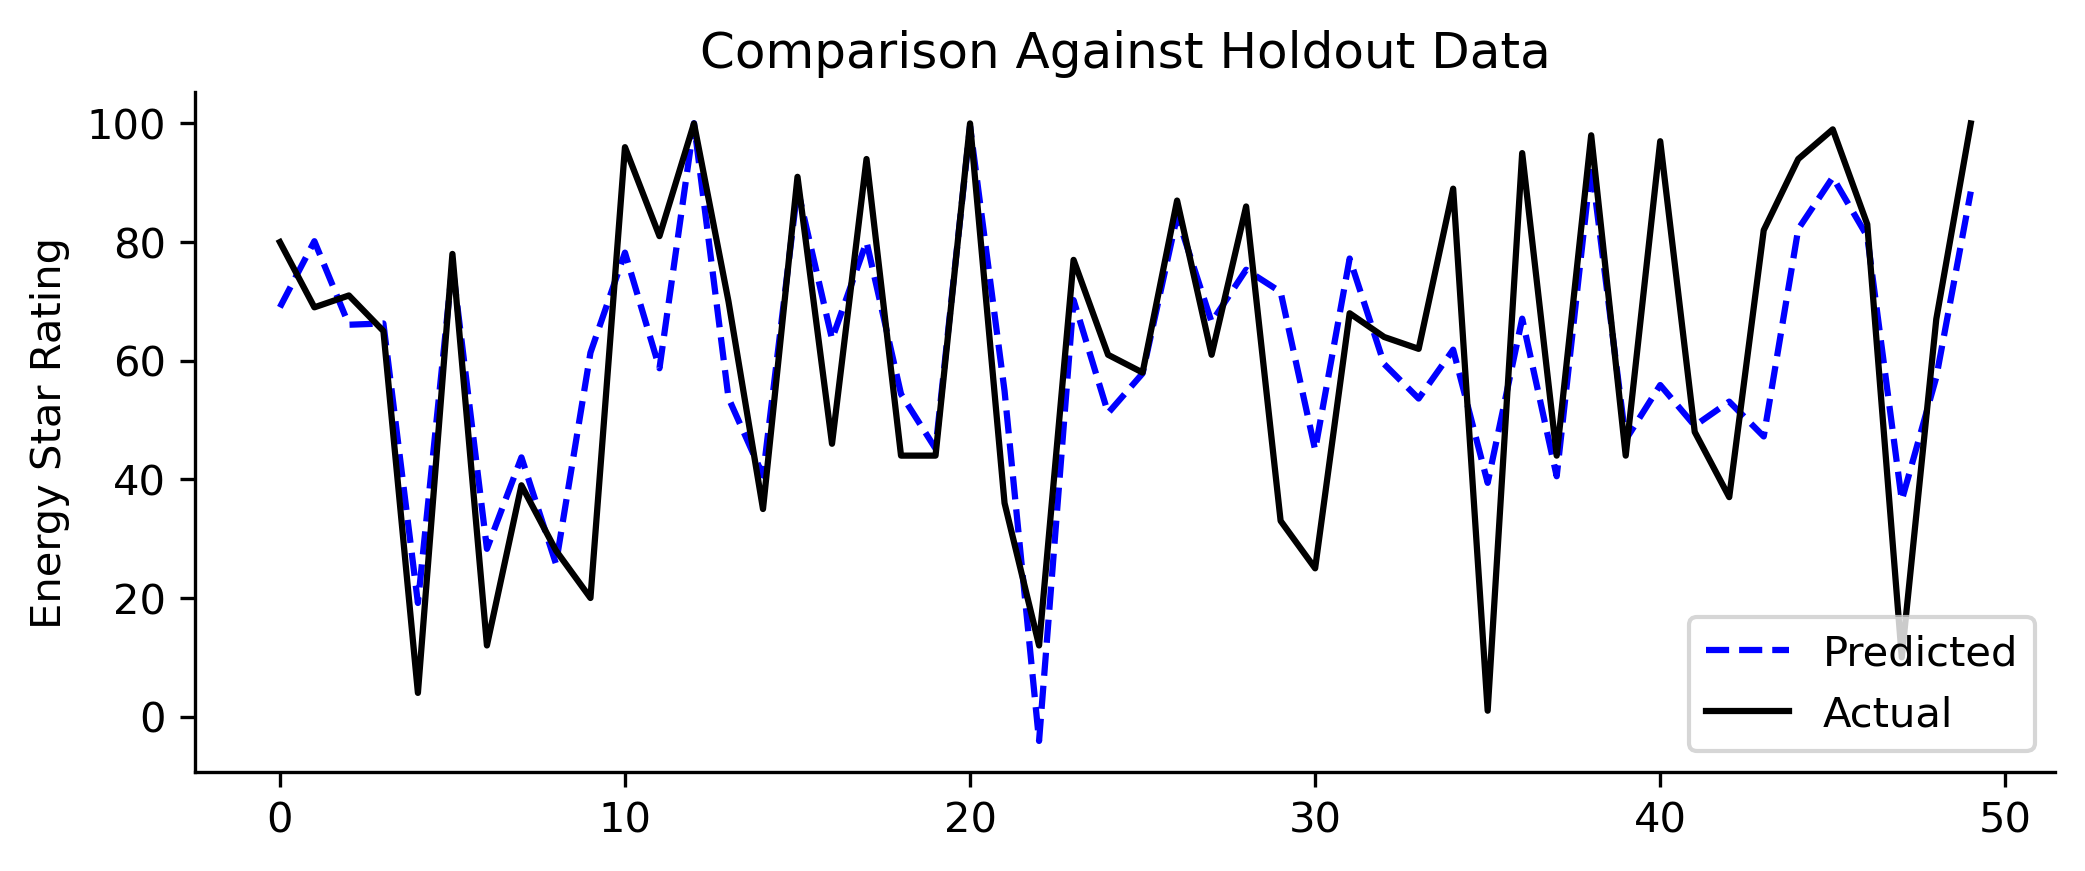

In [85]:
fig = plt.figure(figsize=(8,3),dpi=300)
plt.plot(range(0,len(test_predict[50:100])),test_predict[50:100],'b--',label = 'Predicted')
plt.plot(range(0,len(target_test['energy_star_rating'][50:100])),target_test['energy_star_rating'][50:100],'k-',label = 'Actual')
#plt.gca().set_ylim(3500,10000)
plt.ylabel('Energy Star Rating')
#plt.gca().set_xticks(range(0,20,3))
#plt.gca().set_xticklabels(y_test.index.map(lambda x:x.strftime("%Y-%m")),rotation=45)
plt.legend()
plt.title('Comparison Against Holdout Data')
sns.despine()
plt.show()

**Impute missing data with model.**

In [108]:
target_missing[target_var] = cat.predict(target_missing.drop(target_var,axis=1))
train.loc[train[target_var].isna(),target_var] = target_missing[target_var]

### 2.2 Max Wind Speed

In [73]:
cormat = train[['direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed','days_with_fog','site_eui','energy_star_rating','Year_Factor']].corr()
round(cormat,2)

,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,energy_star_rating,Year_Factor
direction_max_wind_speed,1.00,1.00,0.99,0.33,0.01,-0.00,0.23
direction_peak_wind_speed,1.00,1.00,0.99,0.33,0.01,0.00,0.21
max_wind_speed,0.99,0.99,1.00,0.35,0.01,-0.00,0.23
days_with_fog,0.33,0.33,0.35,1.00,-0.06,0.02,0.62
site_eui,0.01,0.01,0.01,-0.06,1.00,-0.51,-0.05
energy_star_rating,-0.00,0.00,-0.00,0.02,-0.51,1.00,-0.01
Year_Factor,0.23,0.21,0.23,0.62,-0.05,-0.01,1.00


**Since all the wind speed columns are highly correlated to one another, we'll only impute one. We won't impute days_with_fog since it's not as correlated to site_eui.**

In [110]:
target_var = 'max_wind_speed'

#Remove all NA columns except for the target variable we are imputing
df_na = train.drop(['direction_max_wind_speed','direction_peak_wind_speed','days_with_fog','site_eui'],axis=1) 

#Fill missing year columns with 0s
df_na[['year_built','year_built_cat']] = df_na[['year_built','year_built_cat']].fillna(0)
df_na = pd.get_dummies(df_na)

#All rows where the variable is NA go into target_missing; the rest go into target_present
target_missing = df_na.loc[df_na[target_var].isnull()==True].copy()
target_present = df_na.loc[df_na[target_var].isnull()==False].copy()
    
#Set aside some data to test the imputation model
target_train, target_test = train_test_split(target_present, test_size=0.2, random_state=42)
target_train.shape, target_test.shape

((27740, 159), (6935, 159))

In [112]:
cat, test_predict, summary = impute_data(target_var, target_train, target_test, num_features_to_select=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 4.8865968	best: 4.8865968 (0)	total: 3.37s	remaining: 30.3s
1:	loss: 4.8901805	best: 4.8865968 (0)	total: 7.23s	remaining: 28.9s
2:	loss: 6.9111814	best: 4.8865968 (0)	total: 8.21s	remaining: 19.2s
3:	loss: 1.0376933	best: 1.0376933 (3)	total: 9.95s	remaining: 14.9s
4:	loss: 0.8922293	best: 0.8922293 (4)	total: 12.7s	remaining: 12.7s
5:	loss: 0.9009264	best: 0.8922293 (4)	total: 18.1s	remaining: 12.1s
6:	loss: 0.8627541	best: 0.8627541 (6)	total: 23.9s	remaining: 10.3s
7:	loss: 1.0666033	best: 0.8627541 (6)	total: 27.1s	remaining: 6.76s
8:	loss: 0.8638088	best: 0.8627541 (6)	total: 39.5s	remaining: 4.39s
9:	loss: 0.8664409	best: 0.8627541 (6)	total: 50.9s	remaining: 0us
Estimating final quality...


In [113]:
print("RMSE of holdout data is ", round(rmse(target_test[target_var],test_predict),2))

RMSE of holdout data is  0.83


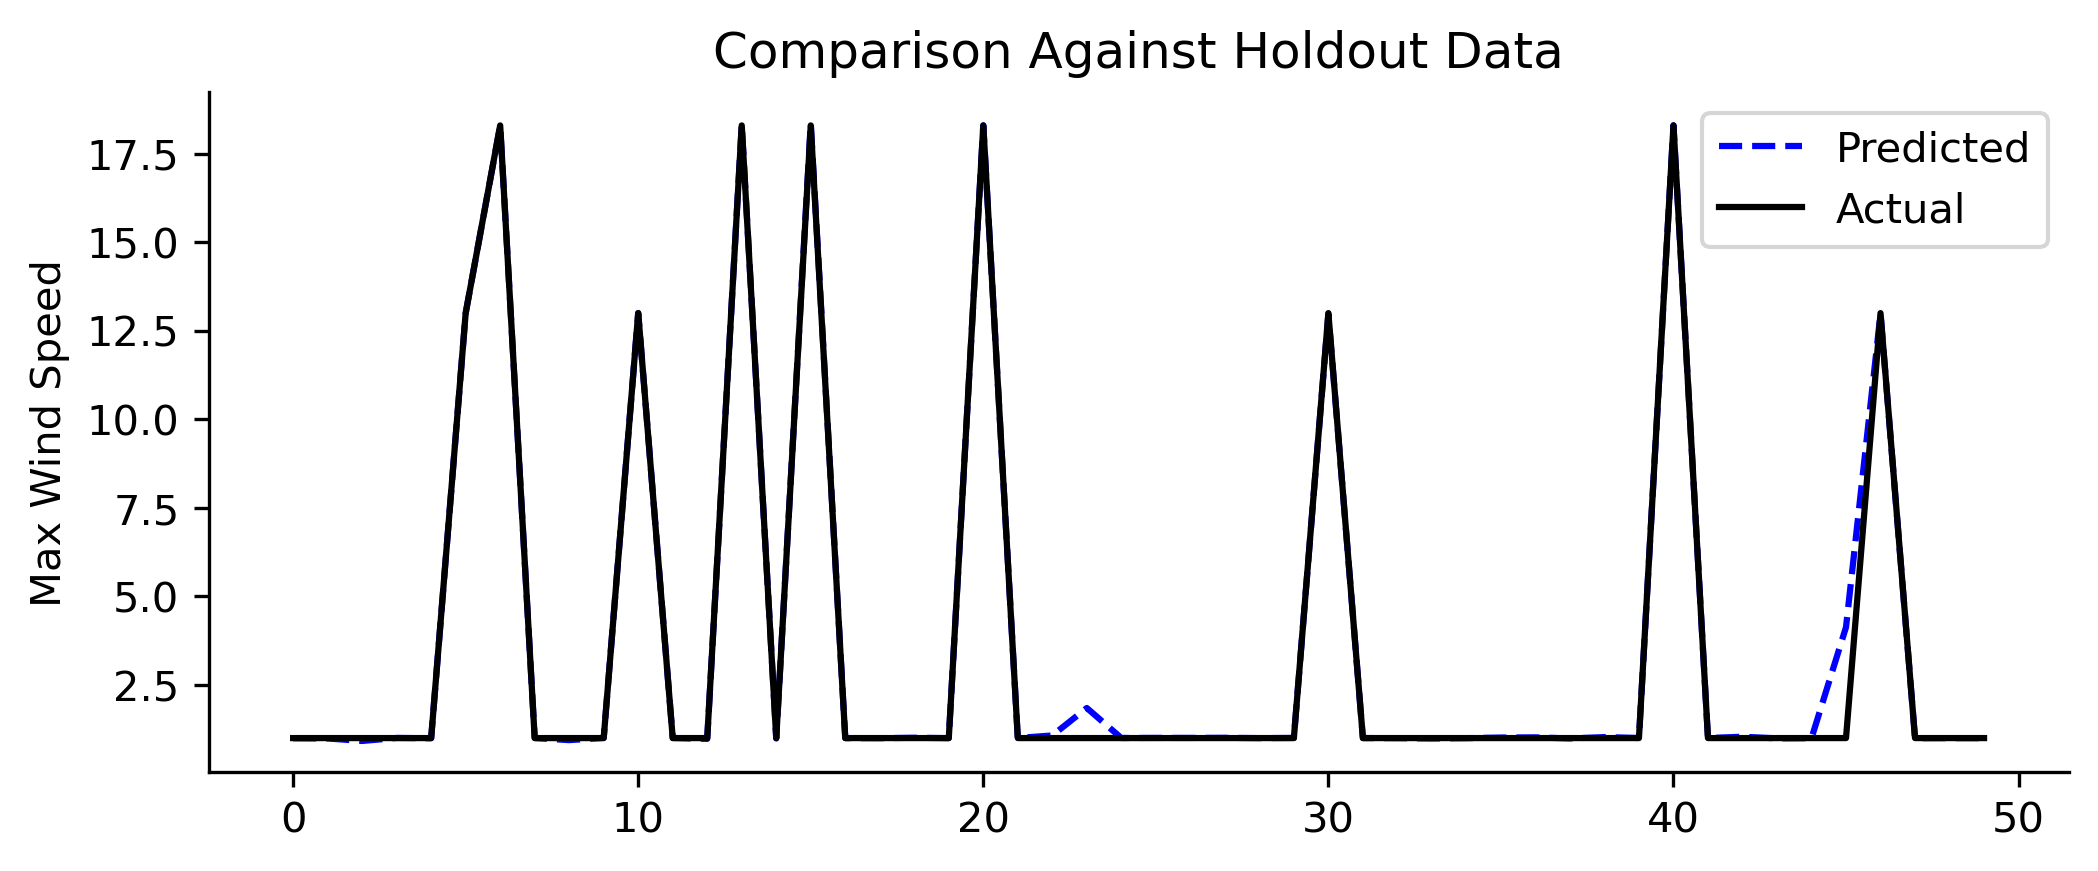

In [114]:
fig = plt.figure(figsize=(8,3),dpi=300)
plt.plot(range(0,len(test_predict[50:100])),test_predict[50:100],'b--',label = 'Predicted')
plt.plot(range(0,len(target_test[target_var][50:100])),target_test[target_var][50:100],'k-',label = 'Actual')
#plt.gca().set_ylim(3500,10000)
plt.ylabel('Max Wind Speed')
#plt.gca().set_xticks(range(0,20,3))
#plt.gca().set_xticklabels(y_test.index.map(lambda x:x.strftime("%Y-%m")),rotation=45)
plt.legend()
plt.title('Comparison Against Holdout Data')
sns.despine()
plt.show()

In [116]:
target_missing[target_var] = cat.predict(target_missing.drop(target_var,axis=1))
train.loc[train[target_var].isna(),target_var] = target_missing[target_var]
train[target_var].isna().sum()

ValueError: Must have equal len keys and value when setting with an iterable

In [117]:
train.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,deviation_October,deviation_November,deviation_December,facility_cat,Component 1,Component 2,Component 3,Component 4,Kmeans clusters,extreme_temp_days
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,154.5,426.0,580.5,eui_250_180,-7.858960,-3.919021,2.995271,0.025138,2,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,154.5,426.0,580.5,eui_50below,-8.078417,-3.963522,3.093942,0.132618,2,0
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,154.5,426.0,580.5,eui_90_70,-8.080195,-3.963893,3.094751,0.133525,2,0
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,154.5,426.0,580.5,eui_70_50,-8.056851,-3.959025,3.084134,0.121607,2,0
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,154.5,426.0,580.5,eui_50below,-8.099929,-3.969274,3.104862,0.148163,2,0


<a href='#methods'>Go to start of section </a>

<a id='models'></a>
# SECTION 4: Model Development using XGBoost

**These are the steps we will take in this section to develop out model:**

1. Feature Selection 
2. Tune Hyperparameters
3. Evaluate with Validation  Data
4. Train Model

## 1. Feature Selection 

## 2. Tune Hyperparameters

In [9]:
#Import libraries for Bayesian hyperparameter tuning 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll import scope

In [10]:
#Define a function to calculate the RMSE 
def rmse(a,p):
    return np.sqrt(mse(a,p))

In [11]:
#Split the training data into train and validation sets 
y = raw_train['site_eui'].to_numpy()
X = raw_train.loc[:, raw_train.columns != 'site_eui'].to_numpy()
seed = 7
test_size = 0.33
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed)

In [12]:
#Define the tree and fit parameter space
reg_params = {
        'max_depth': scope.int(hp.quniform('max_depth', 5, 20, 1)),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
        'gamma': hp.uniform('gamma', 1, 10),
        'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 8, 1)),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),
        'subsample': hp.uniform('subsample', 0.5, 1.0),
        'n_estimators':scope.int(hp.quniform('n_estimators', 200, 1000, 1)),
        'reg_lambda': hp.uniform('reg_lambda', 0, 100),
        'reg_alpha': hp.uniform('reg_alpha', 1e-5, 0.5),
}

fit_params = {
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10,
    'verbose': False,
    'eval_set': [[X_val, y_val]]
}

space = dict()
space['fit_params'] = fit_params
space['reg_params'] = reg_params

In [13]:
#Define the objective function that will fit the training data and return the corresponding validation rmse
def objective(space):
       
    reg = XGBRegressor(**space['reg_params']) 
    
    reg.fit(X_train, y_train,**space['fit_params'])
    pred = reg.predict(X_val)
    loss = rmse(y_val, pred)
    return {'loss': loss, 'status': STATUS_OK}


In [14]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

In [1]:
best_hyperparams

## 3. Evaluate with Validation Data

In [2]:
params = {'colsample_bytree': 0.7412756467321645,
 'gamma': 8.887625856241593,
 'learning_rate': 0.1814807265839045,
 'max_depth': 12,
 'min_child_weight': 2.0,
 'n_estimators': 2000,
 'reg_alpha': 0.17858063335023094,
 'reg_lambda': 4.194509170055143,
 'subsample': 0.9793480994253306}

reg_xgb = XGBRegressor(**params)
reg_xgb.fit(X_train, y_train)

In [185]:
pred = reg_xgb.predict(X_val)
print ("Validation RMSE is: ", np.round(rmse(pred,y_val),2))

In [180]:
fig = plt.figure(figsize=(8,3),dpi=300)
plt.plot(range(0,len(pred[:50])),pred[:50],'b--',label = 'Predicted')
plt.plot(range(0,len(y_val[:50])),y_val[:50],'k-',label = 'Actual')
#plt.gca().set_ylim(3500,10000)
plt.ylabel('Site EUI')
#plt.gca().set_xticks(range(0,20,3))
#plt.gca().set_xticklabels(y_test.index.map(lambda x:x.strftime("%Y-%m")),rotation=45)
plt.legend()
plt.title('Comparison Against Validation Data')
sns.despine()
plt.show()

## 4. Train Model

In [129]:
test = pd.read_csv('../input/wids2022-climatechange/test.csv')
test.set_index('id',inplace=True)
test['State_Factor'].unique() 

**State_6 is missing from the test data, so when we create dummies, let's add an additional column for State_Factor_State_6.**

In [130]:
test = pd.get_dummies(test)
test['State_Factor_State_6']=0
state6_col = test.pop('State_Factor_State_6')
test.insert(simple_impute_train.columns.get_loc('State_Factor_State_6'), 'State_Factor_State_6', state6_col)

In [137]:
my_imputer = SimpleImputer(strategy='median', missing_values=np.nan)

simple_impute_test = pd.DataFrame(my_imputer.fit_transform(test),columns = test.columns,index = test.index)

print ("Number of NAs:", simple_impute_test.isna().sum().sum())

In [80]:
params = {'colsample_bytree': 0.6320733551887876,
 'gamma': 5.139248232526415,
 'learning_rate': 0.06219918776297434,
 'max_depth': 15,
 'min_child_weight': 3.0,
 'n_estimators': 443,
 'subsample': 0.960473156040482}

reg_xgb = XGBRegressor(**params)
reg_xgb.fit(X, y)

In [156]:
pred_test = pd.DataFrame(reg_xgb.predict(simple_impute_test),index = simple_impute_test.index,columns = ['site_eui'])
pred_test.to_csv('ng_solution.csv')